In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from tqdm import tqdm

In [2]:
class_names = ["mountain", "street", "glacier", "buildings", "sea", "forest"]
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

In [3]:
def load_data():
    datasets = ["/kaggle/input/intel-image-classification/seg_train/seg_train", "/kaggle/input/intel-image-classification/seg_test/seg_test"]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print(f"Loading {dataset}")
        
        # Iterate through each folder
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img = cv2.imread(os.path.join(os.path.join(dataset, folder), file))   
                
                # Append the image and its corresponding label to the output
                images.append(img)
                labels.append(label)
                
        labels = np.array(labels, dtype = "int32")    
        
        output.append((images, labels))
        
    return output

In [4]:
def load_pred_data():
    dataset = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"
    images = []
    
    print(f"Loading {dataset}")
    
    # Iterate through each folder
    for img in tqdm(os.listdir(dataset)):
        img = cv2.imread(os.path.join(dataset, img))   
        # Append the image
        images.append(img)

    return images

In [5]:
(train_images, train_labels), (test_images, test_labels)= load_data()
pred_images = load_pred_data()

Loading /kaggle/input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:10<00:00, 218.89it/s]


Loading /kaggle/input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:02<00:00, 242.45it/s]


Loading /kaggle/input/intel-image-classification/seg_pred/seg_pred


100%|██████████| 7301/7301 [00:40<00:00, 178.30it/s]


In [6]:
def display_random_images(n_imgs, color = "color", resize = "No", img_size = None):
    if n_imgs <= 5:
        fig, ax = plt.subplots(1, n_imgs, figsize = (16, 4))
    else:
        n_rows = n_imgs // 4 + 1
        fig, ax = plt.subplots(n_rows, 4, figsize = (20, 20))
    ax = ax.ravel()   
    
    image_shape = set()
    for i in range(n_imgs):
        random_idx = np.random.randint(len(train_images))
        img = train_images[random_idx]

        if resize == "Yes":
            if img_size is None:
                print("Error: image size is None")
                return
            img = cv2.resize(img, img_size)
            
        if color != "color":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax[i].imshow(img, cmap = "gray")
        else:
            ax[i].imshow(img)
        image_shape.add(img.shape)
    print(image_shape)           
    plt.show()
        

{(150, 150, 3)}


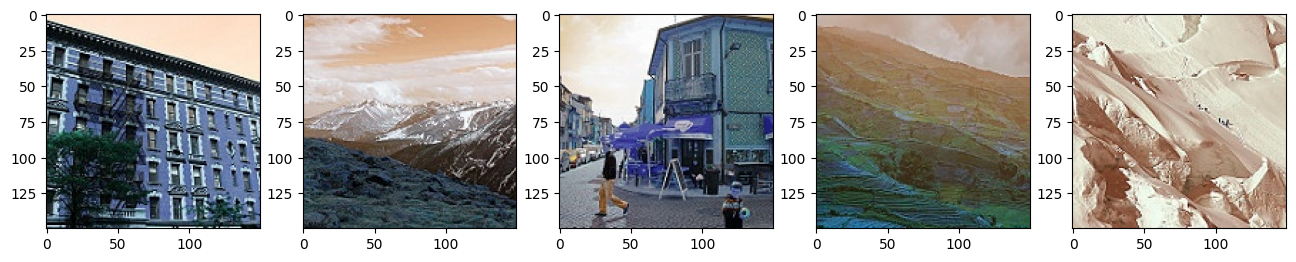

In [7]:
display_random_images(5)

{(150, 150)}


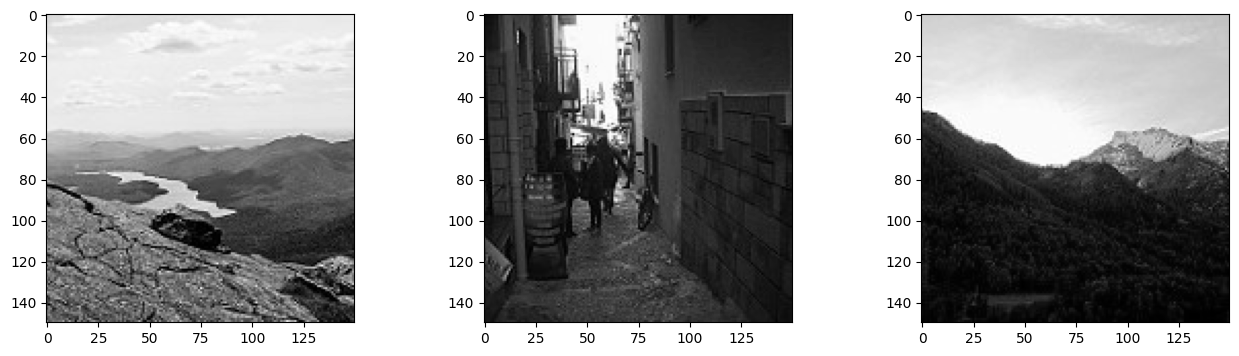

In [8]:
display_random_images(3, color = "gray")

{(100, 120)}


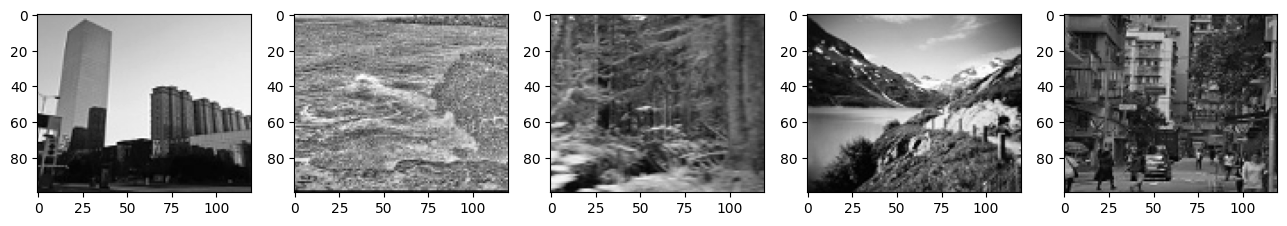

In [9]:
# Choose minimum image size
img_size = (120, 100)
display_random_images(5, color = "gray", resize = "Yes", img_size = img_size)

In [10]:
All_images = {}

# Create a dictionary mapping variable names to actual image arrays
image_dict = {
    "train_images": train_images,
    "test_images": test_images,
    "pred_images": pred_images
}

# Loop through the dictionary
for name, images in image_dict.items():
    temp_images = []
    
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, img_size)
        img = img.reshape(img_size[1], img_size[0], 1)  # reshape to suit the CNN

        temp_images.append(img)
        
    temp_images = np.array(temp_images, dtype="float32")
    
    # Use 'name' as the key in All_images
    All_images[name] = temp_images

# Now you can check the length of the All_images dictionary
len(All_images)

3

In [11]:
shape = set()
for img in All_images["train_images"]:
    shape.add(img.shape)
shape

{(100, 120, 1)}

In [12]:
All_images["train_images"], train_labels = shuffle(All_images["train_images"], train_labels, random_state = 42)

In [13]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print(f"Number of training examples: {n_train}")
print(f"Number of testing examples: {n_test}")
print(f"Each image is of size: {shape}")

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: {(100, 120, 1)}


In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu", input_shape = (img_size[0], img_size[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (5, 5), strides = (3, 3)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, kernel_size = (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1024, activation = "relu"),
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(6, activation = "softmax")])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer = 'adam', loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [16]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 98, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 118, 98, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 116, 96, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 38, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 27, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 9, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,623,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,917,558 (7.31 MB)

 Trainable params: 1,917,430 (7.31 MB)

 Non-trainable params: 128 (512.00 B)

None


In [17]:
history = model.fit(All_images["train_images"], train_labels,
                         validation_split = 0.25,
                         epochs=100,
                         batch_size= 650,
                         verbose= 1,
                         callbacks=[tf.keras.callbacks.EarlyStopping(
                                            patience=10,
                                            monitor='val_accuracy',#"val_loss",
                                            restore_best_weights= True)])

Epoch 1/100


I0000 00:00:1727195913.878500      73 service.cc:145] XLA service 0x7c88e0009d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727195913.878598      73 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-09-24 16:38:48.850376: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[650,32,98,118]{3,2,1,0}, f32[650,32,96,116]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-24 16:38:50.839263: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.989041972s
Trying algorithm eng0{} for conv (f32[32,32,

 1/17 ━━━━━━━━━━━━━━━━━━━━ 6:38 25s/step - accuracy: 0.1923 - loss: 2.5792

I0000 00:00:1727195935.560106      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 853ms/step - accuracy: 0.2133 - loss: 2.2622 - val_accuracy: 0.1812 - val_loss: 2.1669
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.3178 - loss: 1.4862 - val_accuracy: 0.3619 - val_loss: 1.4491
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.4063 - loss: 1.2602 - val_accuracy: 0.4870 - val_loss: 1.2563
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4956 - loss: 1.1623 - val_accuracy: 0.5175 - val_loss: 1.2282
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.5453 - loss: 1.0898 - val_accuracy: 0.4705 - val_loss: 1.1882
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.5957 - loss: 1.0072 - val_accuracy: 0.5361 - val_loss: 1.0900
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.6141 - loss: 0.9620 - val_accuracy: 0.4893 - val_loss: 1.1795
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.6438 - loss: 0.8956 - val_accuracy: 0.609

In [18]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "train")
    plt.plot(history.history['val_accuracy'], label = "validataion")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend(loc = 'upper left')

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "loss")
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend(loc = 'upper left')
    plt.show()

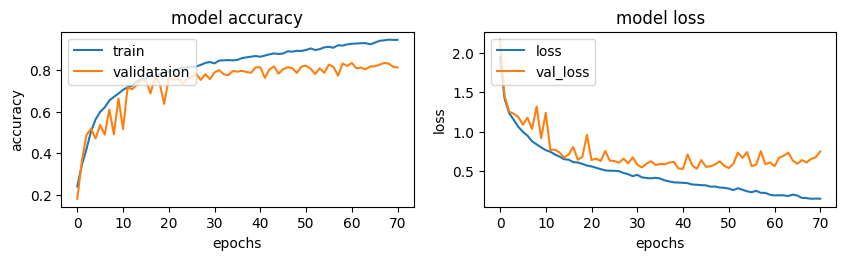

In [19]:
plot_accuracy_loss(history)

In [20]:
model.evaluate(All_images["test_images"], test_labels)[1]

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8066 - loss: 0.6365


0.8299999833106995

In [21]:
pred_labels = model.predict(All_images["test_images"])

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [22]:
pred_labels = np.argmax(pred_labels, axis = 1)

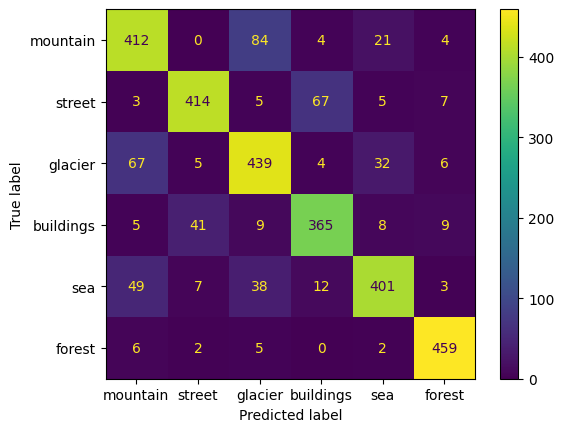

In [23]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
disp.plot()

In [24]:
pred_labels = model.predict(All_images["pred_images"])
pred_labels = np.argmax(pred_labels, axis = 1)

229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


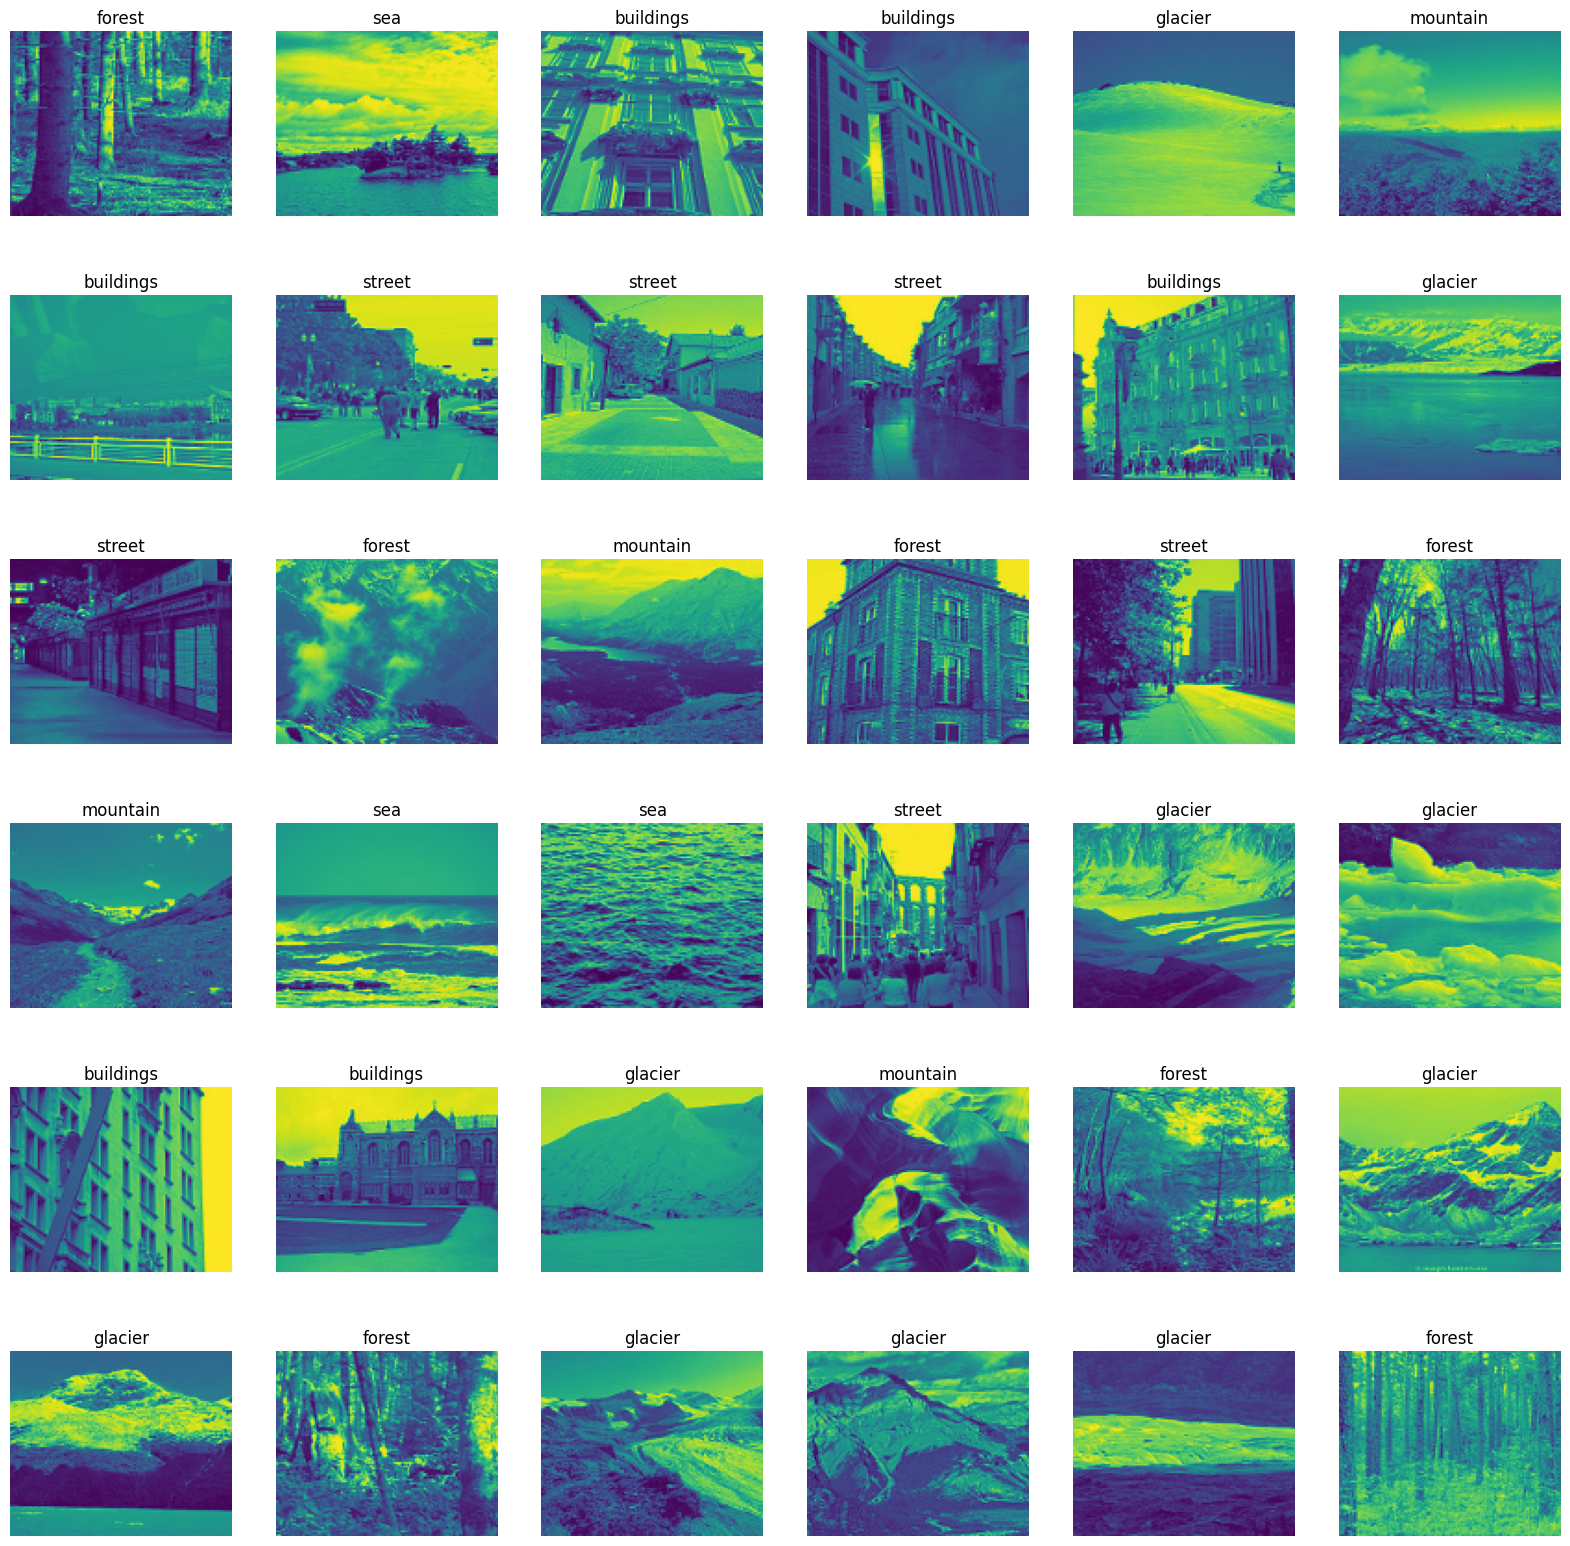

In [25]:
plt.figure(figsize=(20,20))

for n , i in enumerate(list(np.random.randint(0, len(All_images["pred_images"]),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(All_images["pred_images"][i])
    plt.axis('off')
    plt.title(class_names[pred_labels[i]])